In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
import itertools

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from importlib import reload

# local imports
sys.path.append("./")
import utils

In [2]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

# Load our data

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.tabula.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

In [4]:
adata.var_names_make_unique()

# annotate all labels
adata.obs['group'] = np.where(adata.obs['cluster_name'].isna(), "C5", adata.obs['cluster_name'])
adata.obs['group'] = np.where(adata.obs['celltype'] == 'HSC', "C6", adata.obs['group'])

# marker genes

In [5]:
sample_size = 1000

pdf = utils.get_stacked_cell_data(adata, genes='marker')
pdf = sc.pp.subsample(pdf, n_obs=sample_size, copy=True)

# compute the PCA
n_comps = 30
sc.tl.pca(pdf, 
          n_comps=n_comps, 
          use_highly_variable=False)

# compute the UMAP
knn = 31
knn_metric = 'euclidean'
sc.pp.neighbors(pdf, 
                n_neighbors=knn, 
                metric=knn_metric, 
                n_pcs=n_comps)

sc.tl.umap(pdf, n_components=n_comps)

layers = {
    'raw' : pdf.X,
    'pca' : pdf.obsm['X_pca'],
    'umap' : pdf.obsm['X_umap'],
}

print('done')

2024-01-30 13:25:23.671954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 13:25:23.795762: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 13:25:23.825847: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 13:25:24.589947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

done


0 euclidean raw (1000, 206)
0 euclidean pca (1000, 30)
0 euclidean umap (1000, 30)


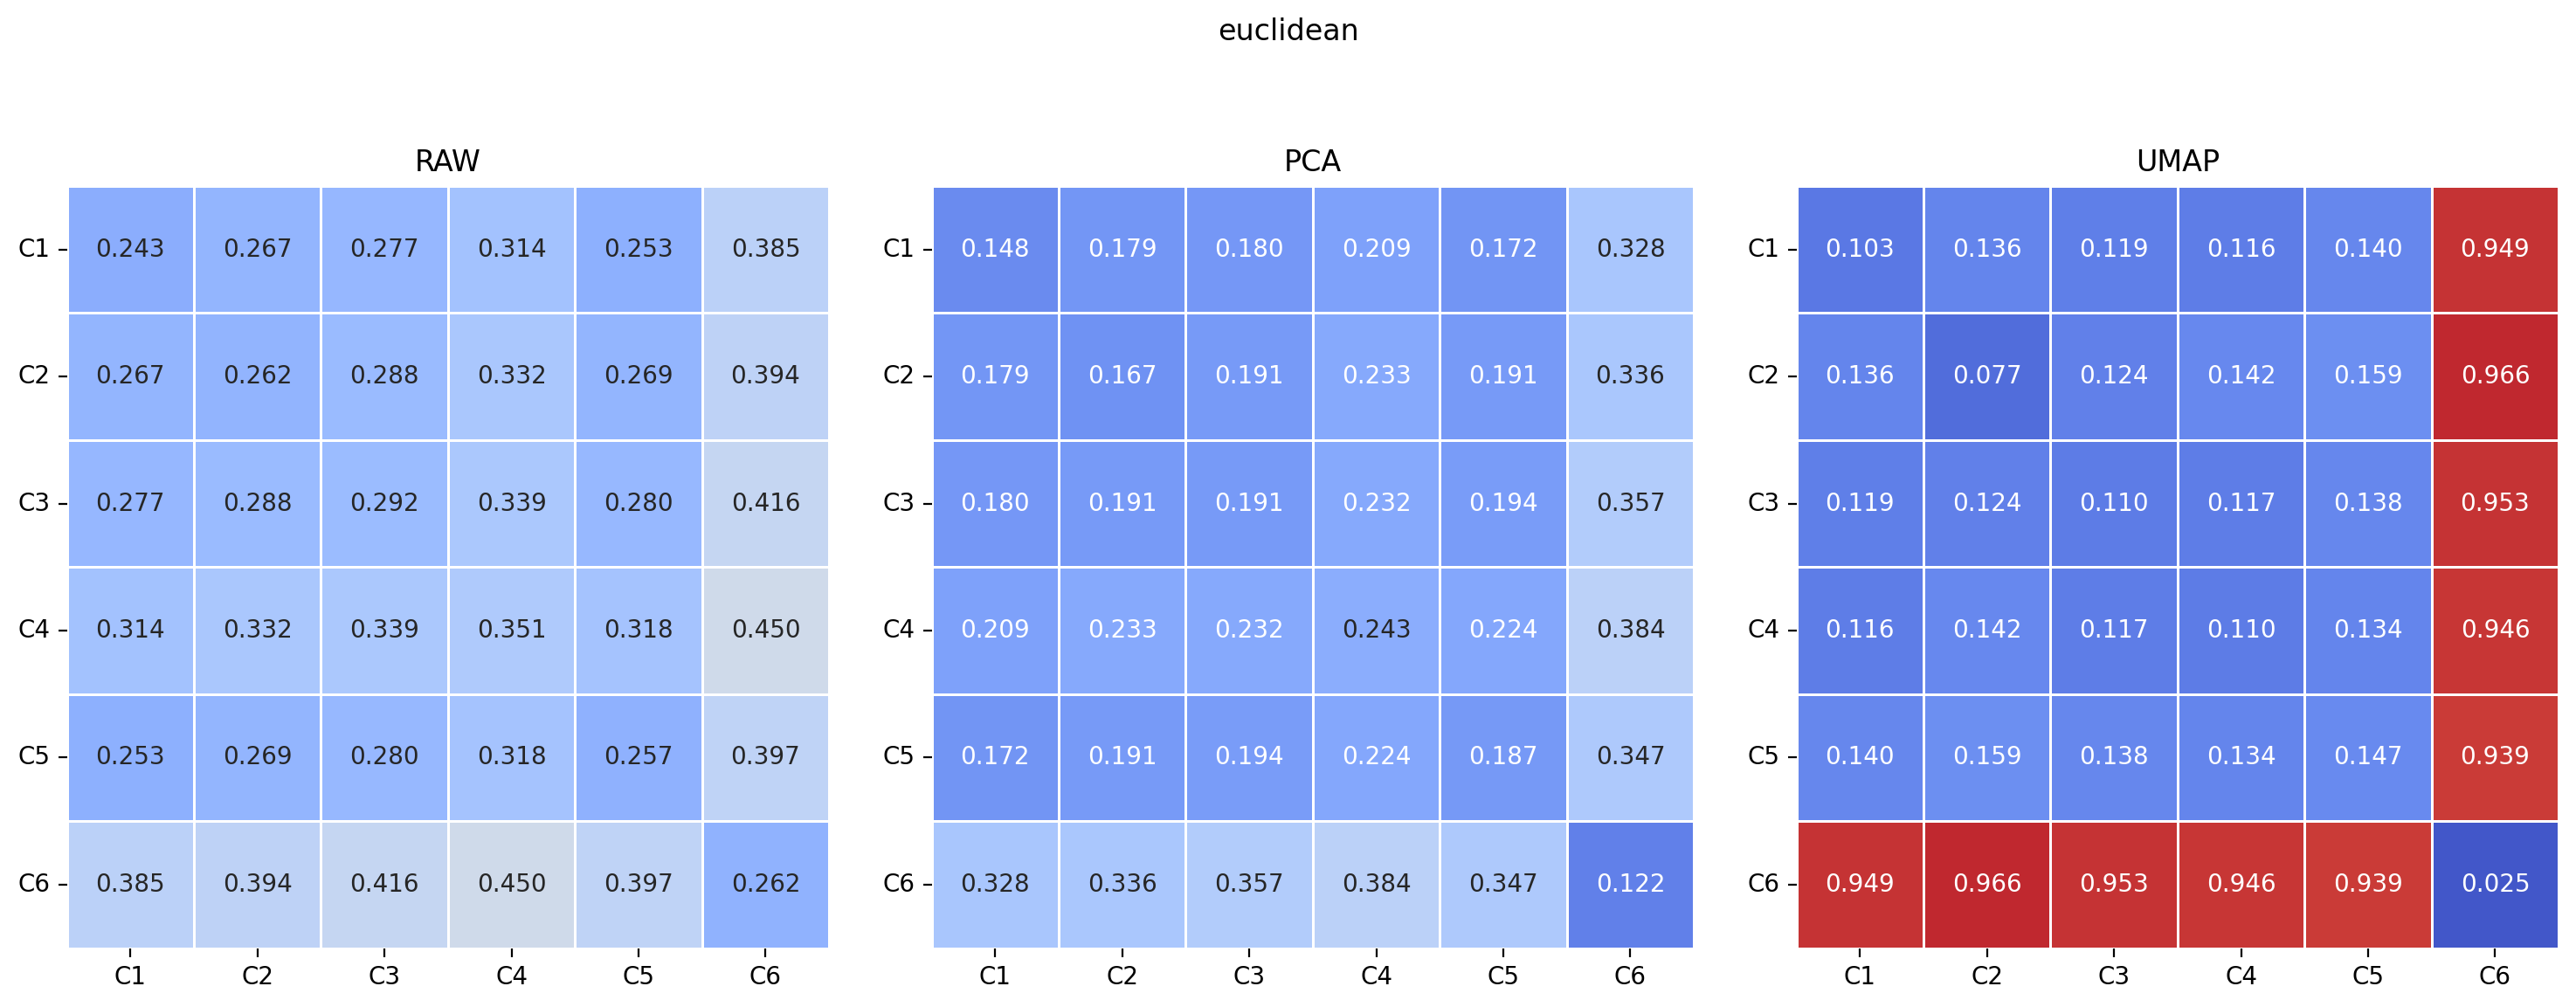

1 cosine raw (1000, 206)
1 cosine pca (1000, 30)
1 cosine umap (1000, 30)


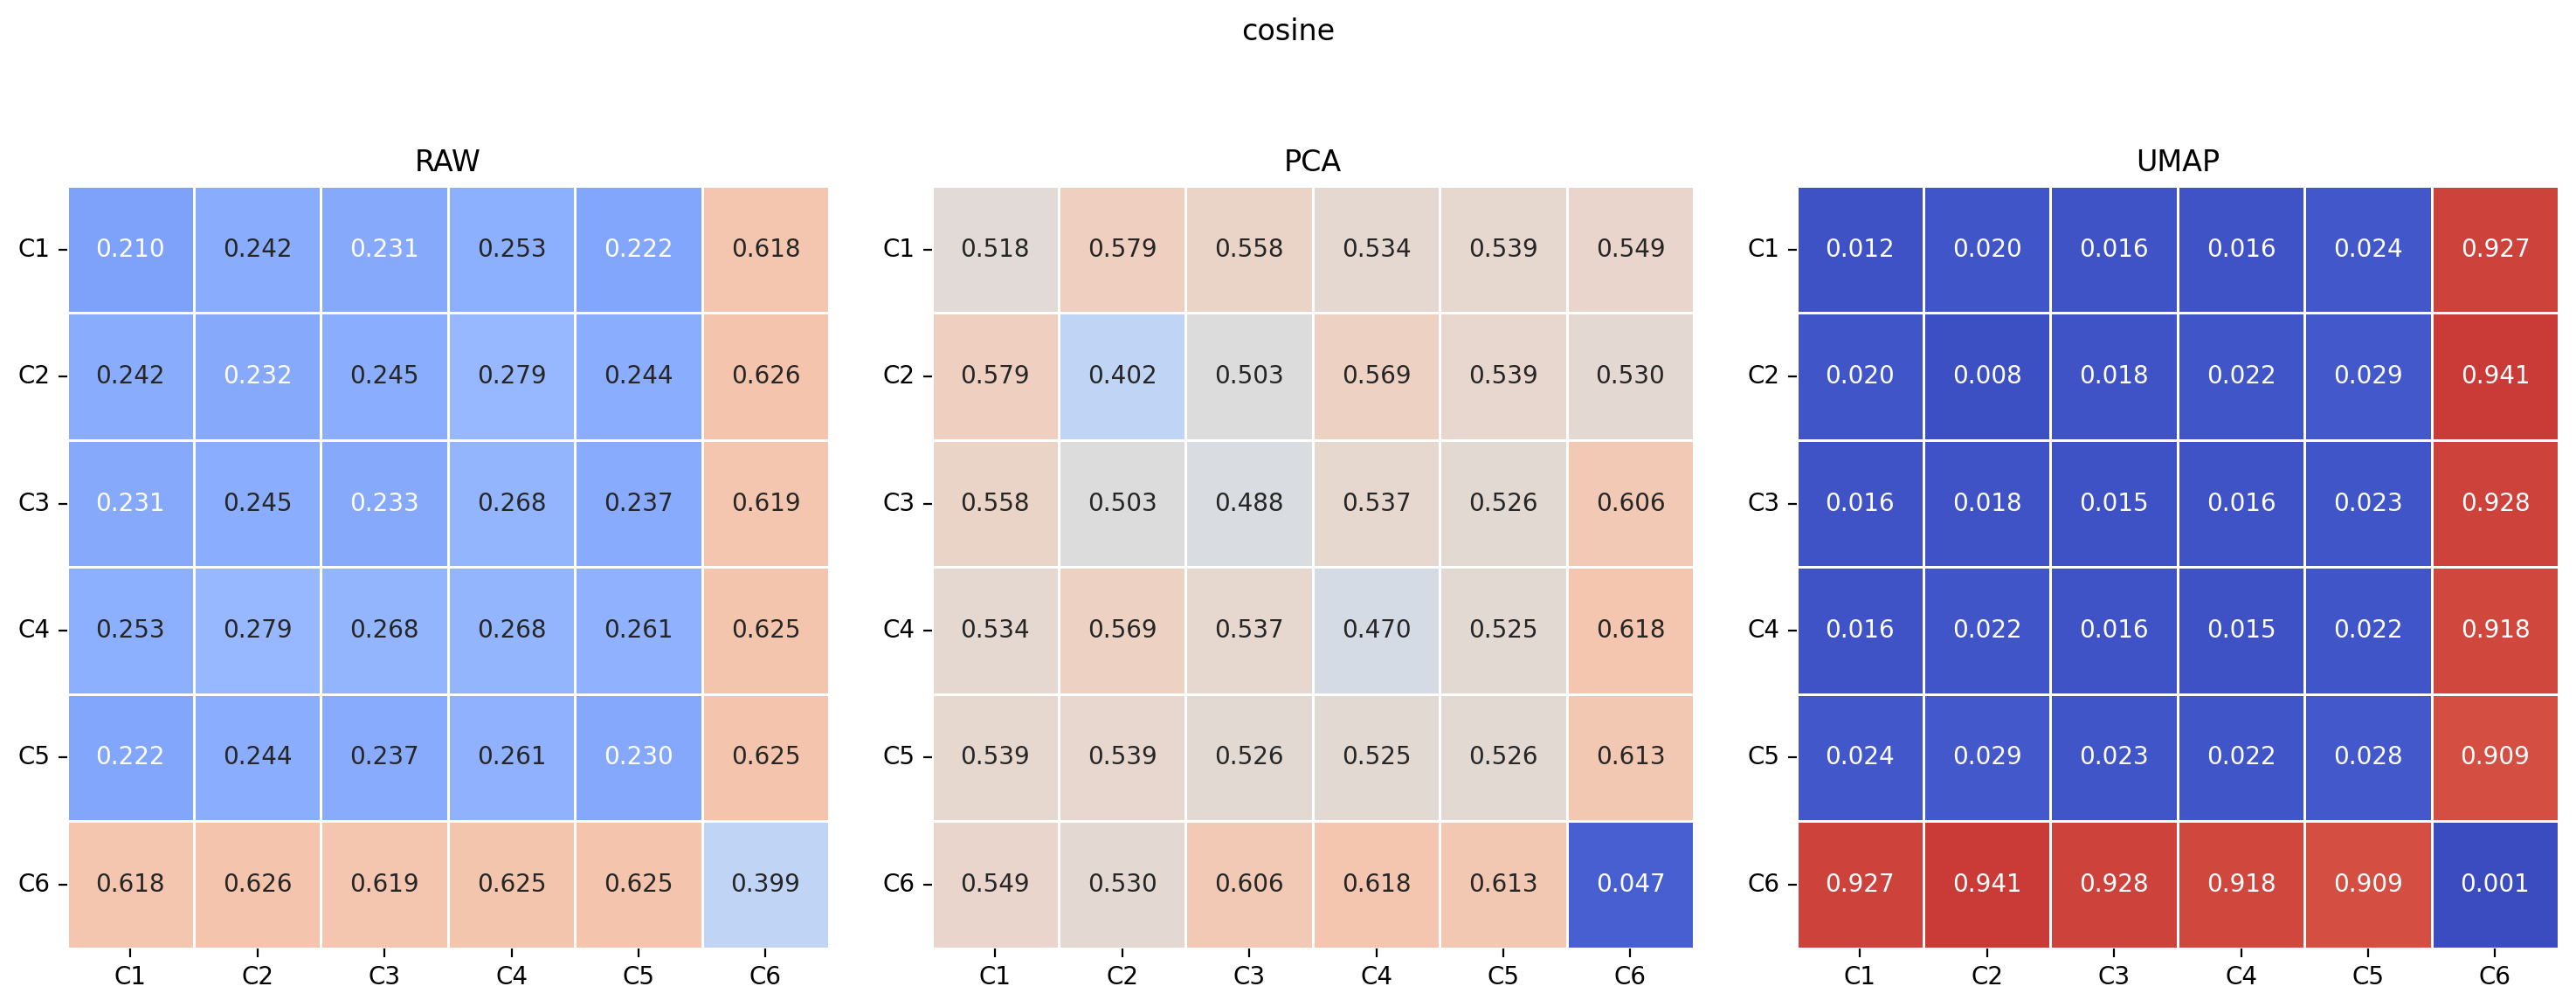

2 correlation raw (1000, 206)
2 correlation pca (1000, 30)
2 correlation umap (1000, 30)


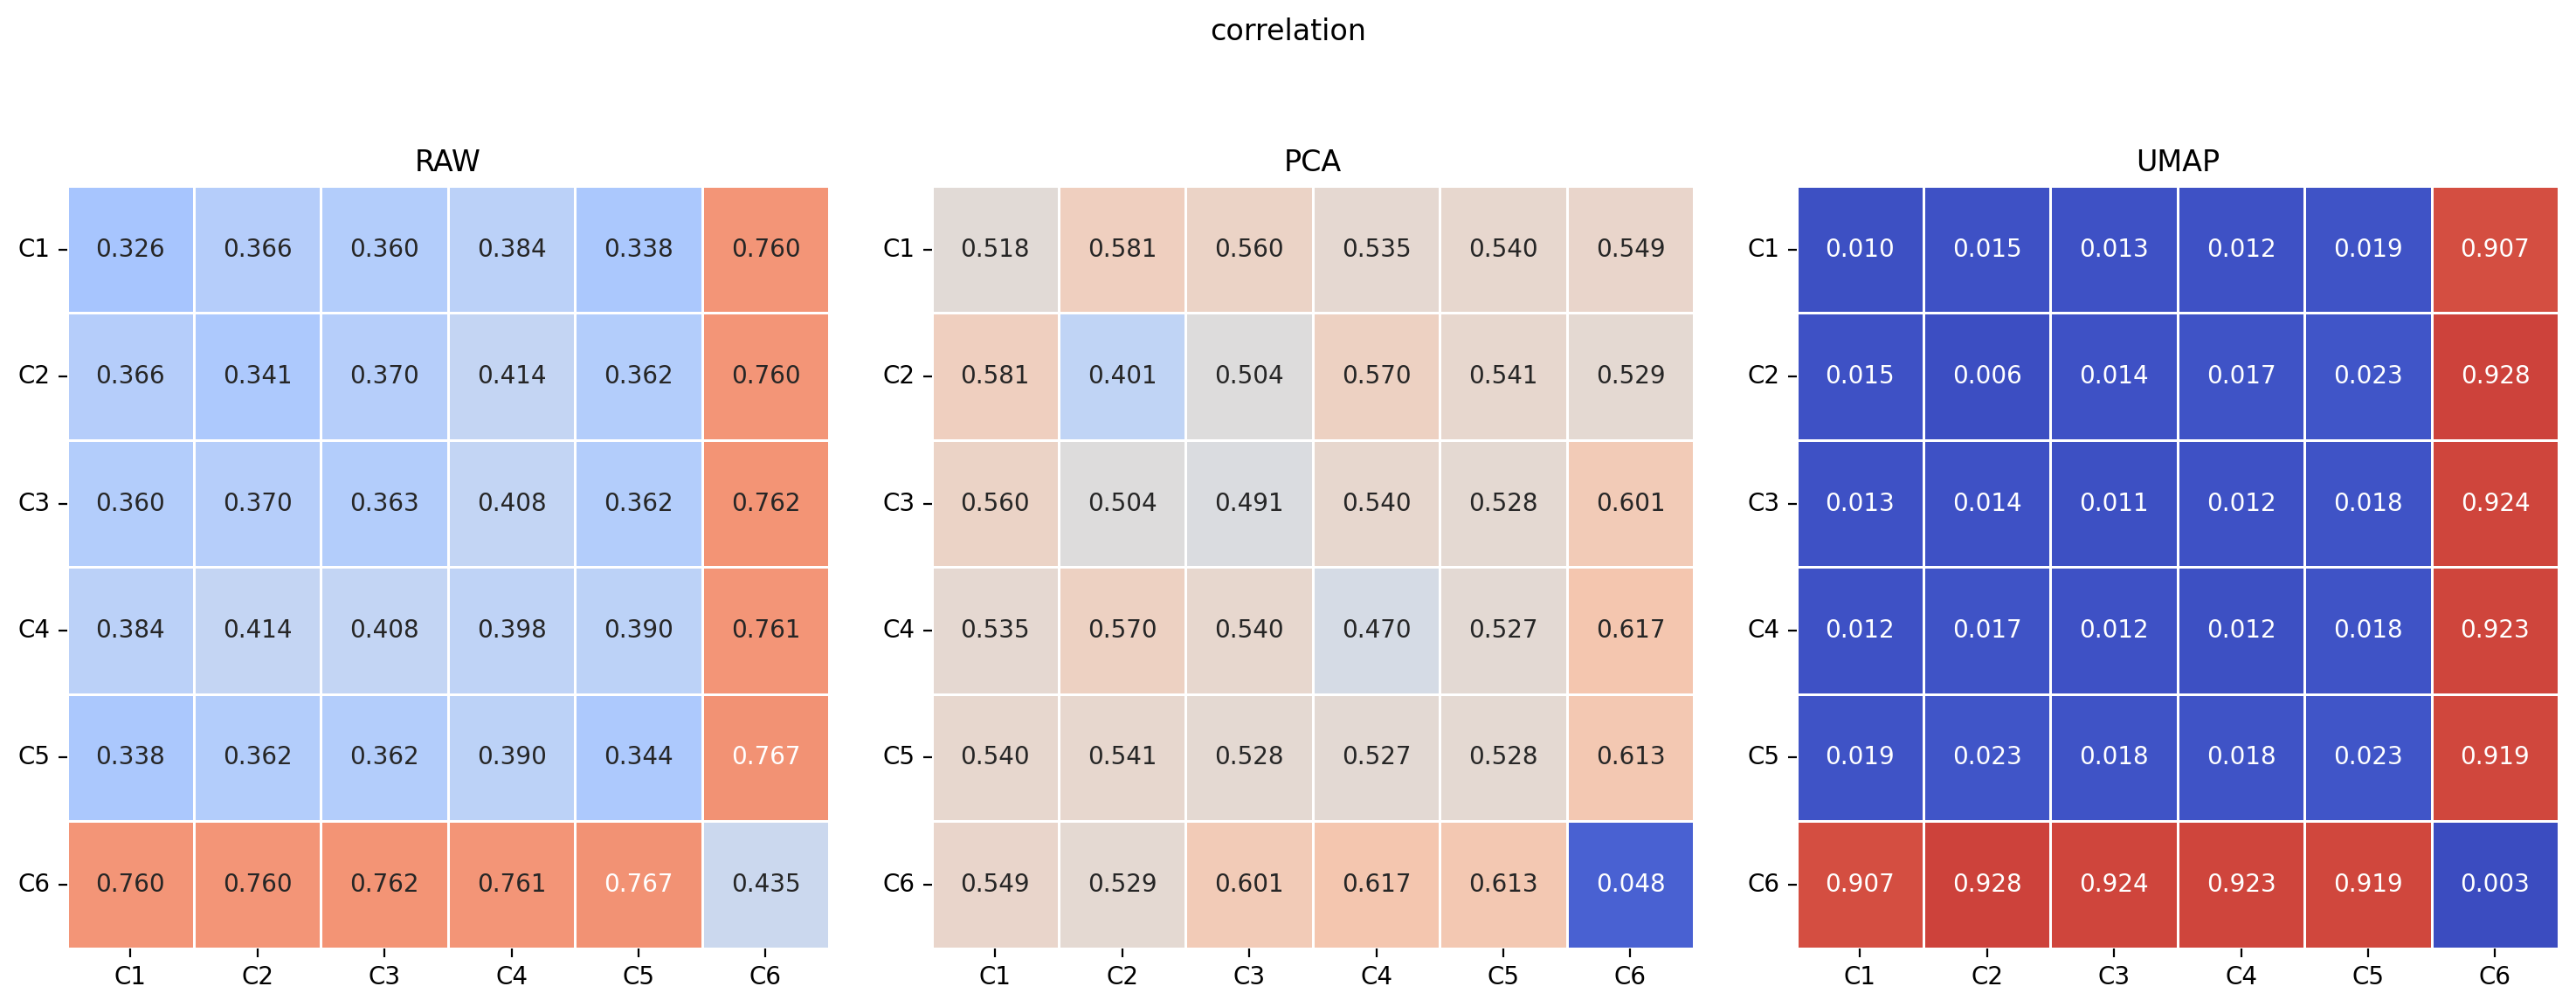

3 jensenshannon raw (1000, 206)
3 jensenshannon pca (1000, 30)
3 jensenshannon umap (1000, 30)


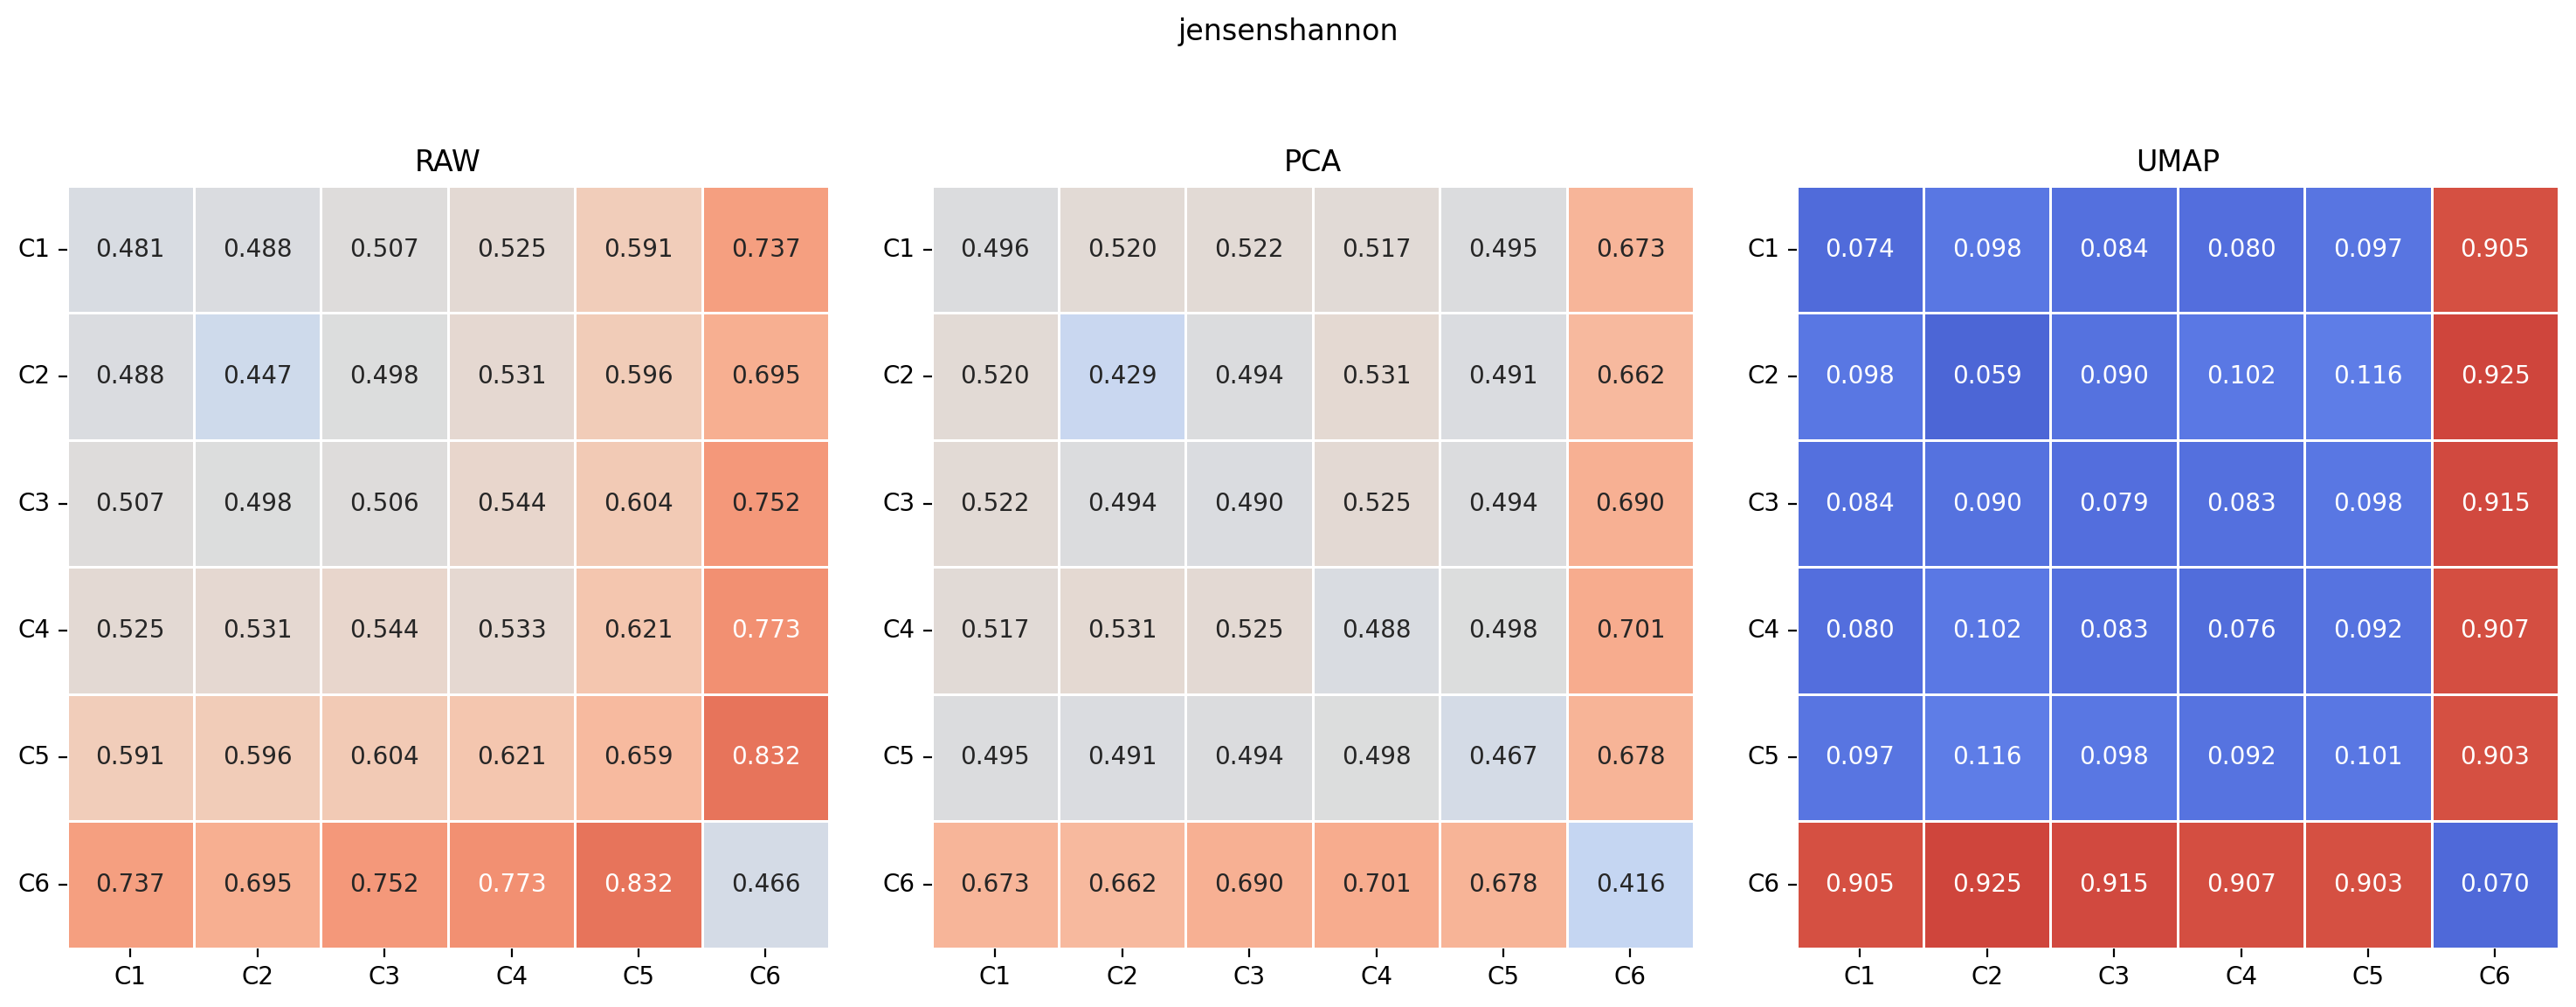

4 <function wasserstein_distance at 0x15314631b310> raw (1000, 206)
4 <function wasserstein_distance at 0x15314631b310> pca (1000, 30)
4 <function wasserstein_distance at 0x15314631b310> umap (1000, 30)


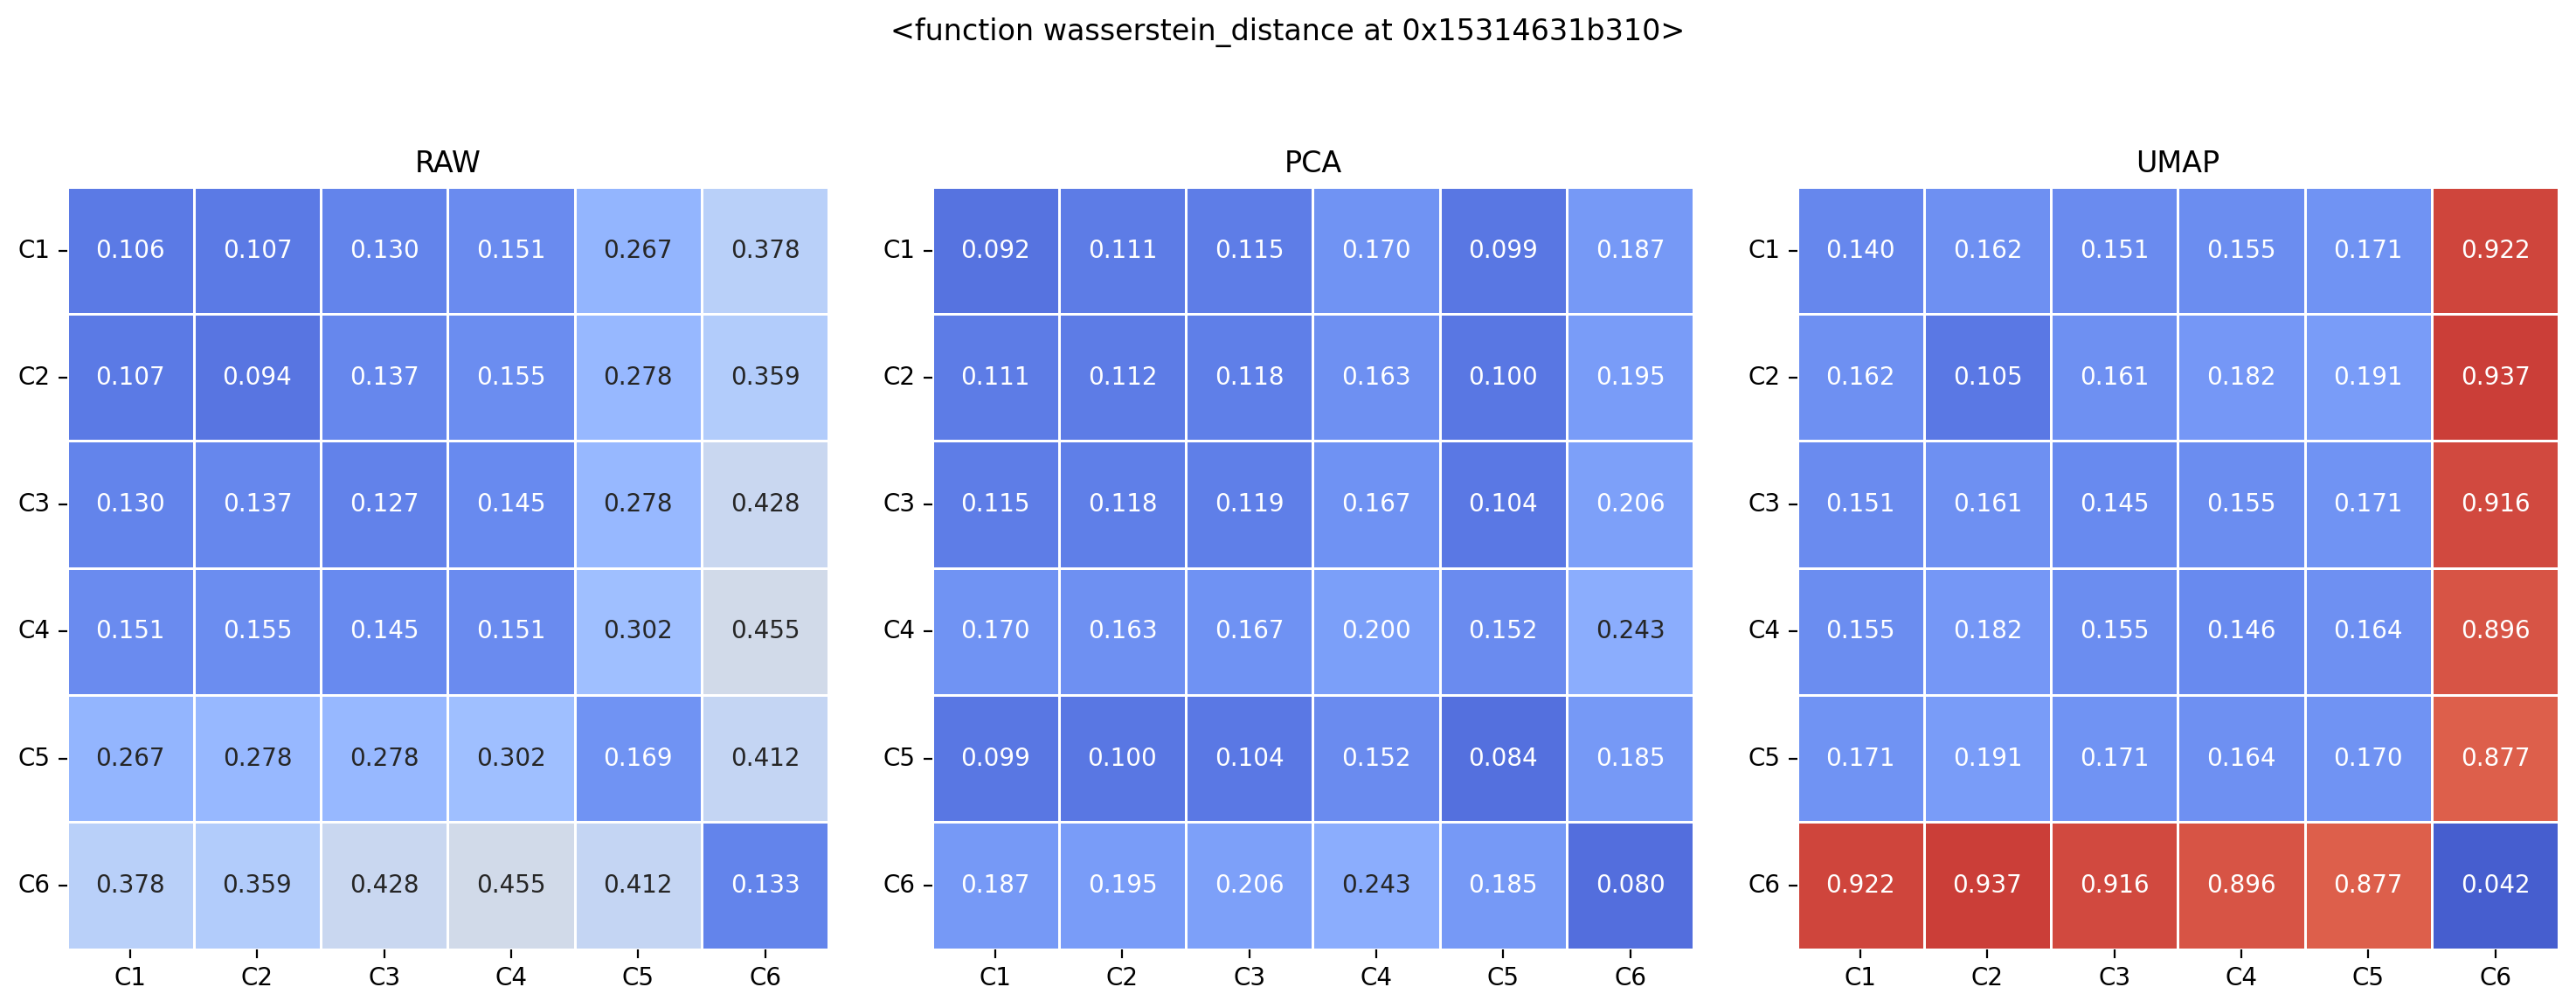

In [7]:
metrics = [
    'euclidean',
    'cosine',
    'correlation',
    'jensenshannon',
    scipy.stats.wasserstein_distance
]

cmap = 'coolwarm'

def get_mean_D(D, pdf):
    """A function to compute group mean statistics """
    # average distances
    res = []
    
    for i_name, group_i in pdf.obs.groupby('group'):
        for j_name, group_j in pdf.obs.groupby('group'):
            i_idx = group_i.index
            j_idx = group_j.index
        
            mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())
        
            row = {
                'i_name' : i_name,
                'j_name' : j_name,
                'mean_dist' : mean_dist,
            }
        
            res.append(row)
            
    res = pd.DataFrame(res)
    res = pd.pivot_table(res, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')
    return res

res = []
for i, metric in enumerate(metrics):

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 15, 5
    fig, axs = plt.subplots(1, 3)
    
    for j, (layer, X) in enumerate(layers.items()):
        print(i, metric, layer, X.shape)

        if metric == 'jensenshannon':
            # normalize the features of the matrix, 
            # since it expects probabilites
            X = preprocessing.minmax_scale(X, 
                                           feature_range=(0, 1),
                                           axis=1)

        # make distance matrix
        D = scipy.spatial.distance.pdist(X, metric=metric)
        
        # normalize the distances
        D = min_max(D)
        D = scipy.spatial.distance.squareform(D)
        D = pd.DataFrame(D, 
                         index=pdf.obs.index, 
                         columns=pdf.obs.index)

        # aggregate
        Dmu = get_mean_D(D, pdf)

        # plot the mean data
        sns.heatmap(Dmu, 
                    square=True,
                    linewidth=0.5,
                    annot=True,
                    cmap=cmap,
                    fmt=".3f",
                    vmin=0,
                    vmax=1,
                    cbar=False,
                    ax=axs[j])

        axs[j].set_title(layer.upper())
        axs[j].set_ylabel("")
        axs[j].set_xlabel("")
        axs[j].tick_params(axis='y', rotation=0)        

    plt.suptitle(metric, y=1.1)
    plt.tight_layout()
    plt.show()

# all genes

In [8]:
# prepare sample
sample_size = 1000

pdf = utils.get_stacked_cell_data(adata, genes=None)
pdf = sc.pp.subsample(pdf, n_obs=sample_size, copy=True)

# compute the PCA
n_comps = 30
sc.tl.pca(pdf, 
          n_comps=n_comps, 
          use_highly_variable=False)

# compute the UMAP
knn = 31
knn_metric = 'euclidean'
sc.pp.neighbors(pdf, 
                n_neighbors=knn, 
                metric=knn_metric, 
                n_pcs=n_comps)

sc.tl.umap(pdf, n_components=n_comps)

layers = {
    'raw' : pdf.X,
    'pca' : pdf.obsm['X_pca'],
    'umap' : pdf.obsm['X_umap'],
}

print('done')

done


# compute distances

0 euclidean raw (1000, 14599)
0 euclidean pca (1000, 30)
0 euclidean umap (1000, 30)


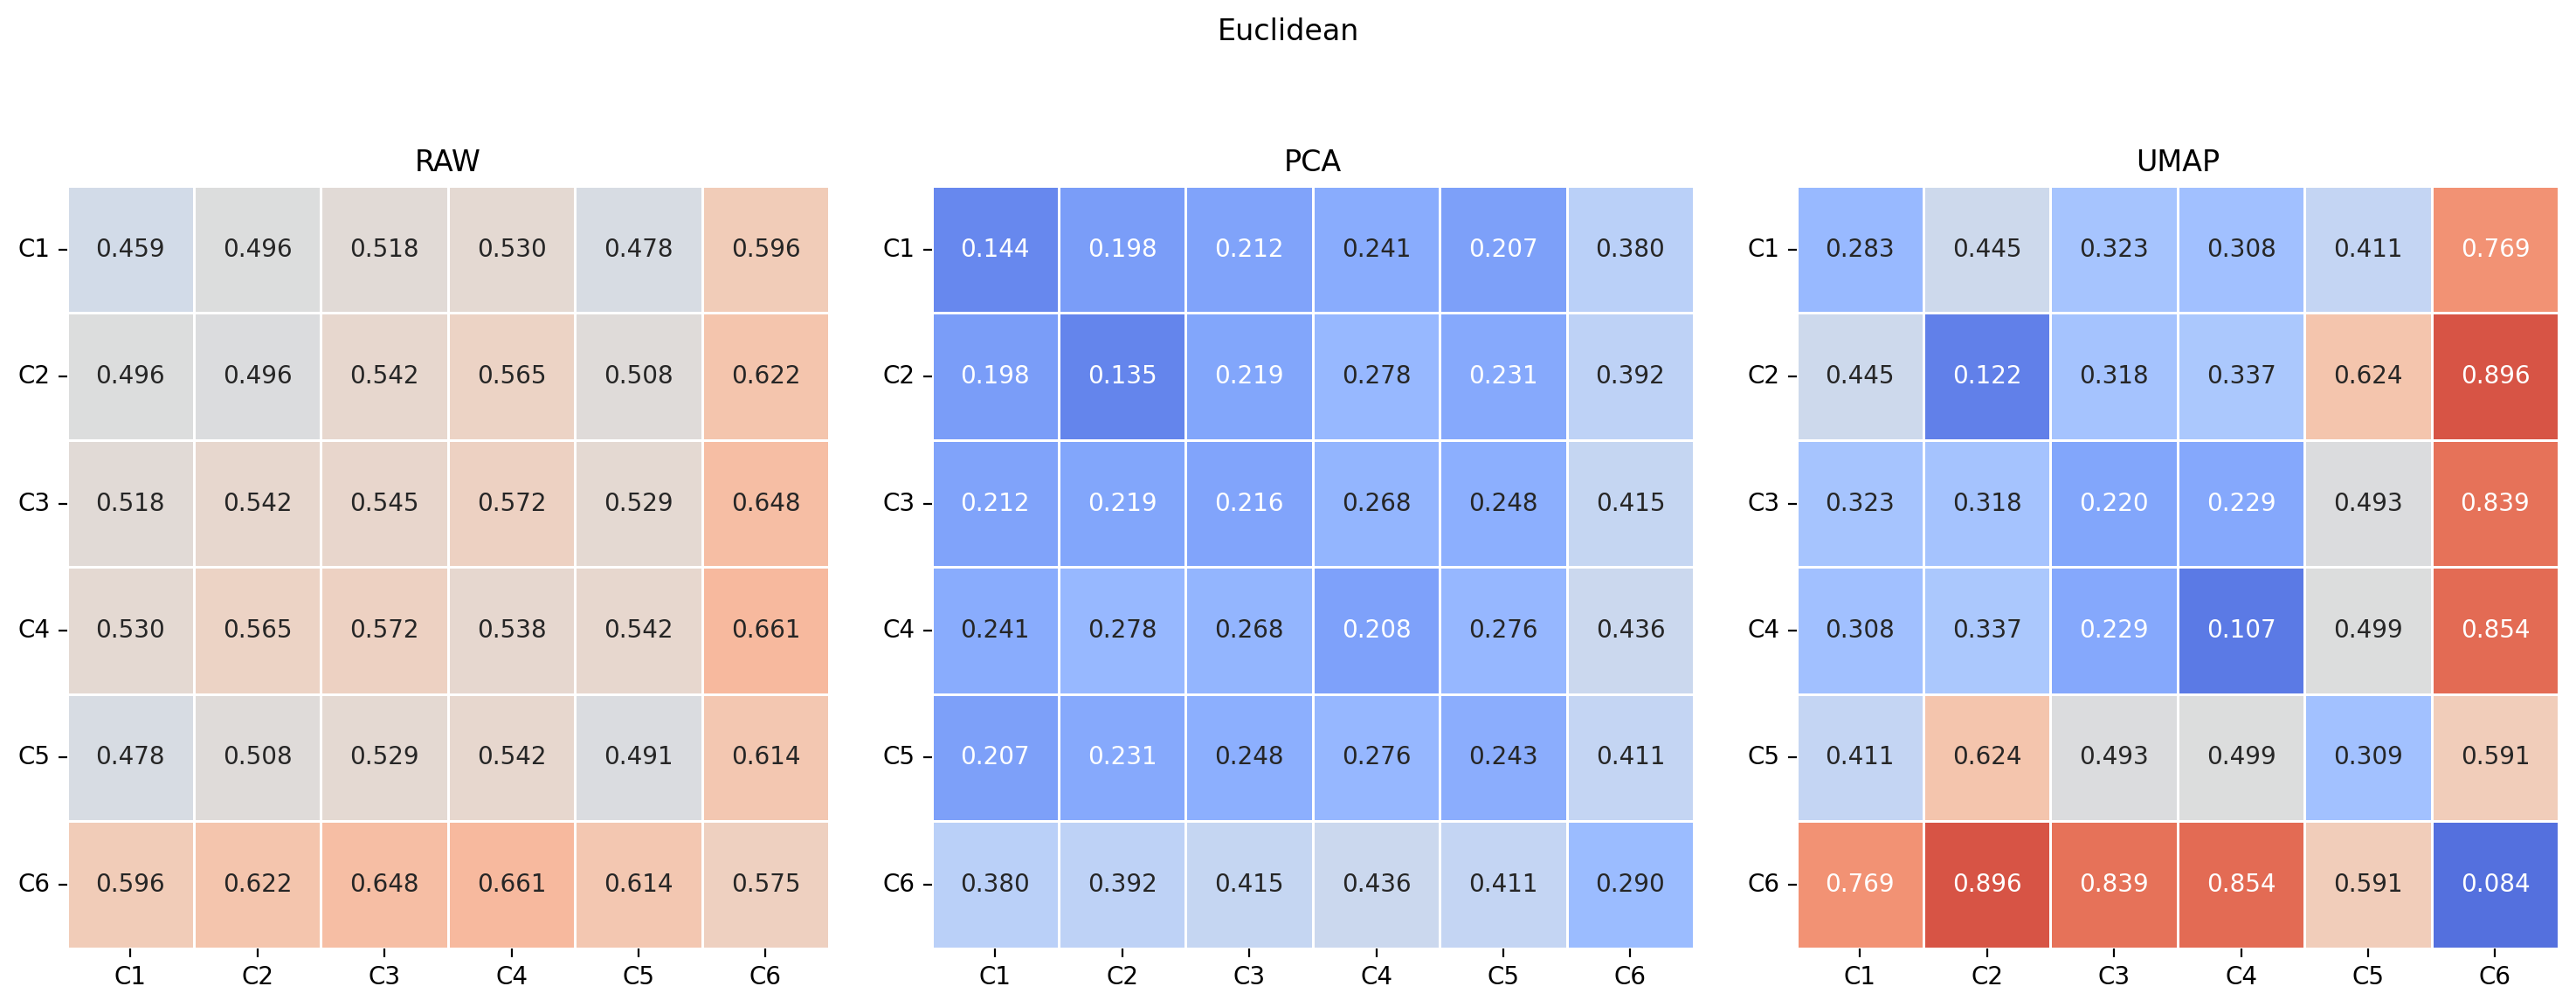

1 cosine raw (1000, 14599)
1 cosine pca (1000, 30)
1 cosine umap (1000, 30)


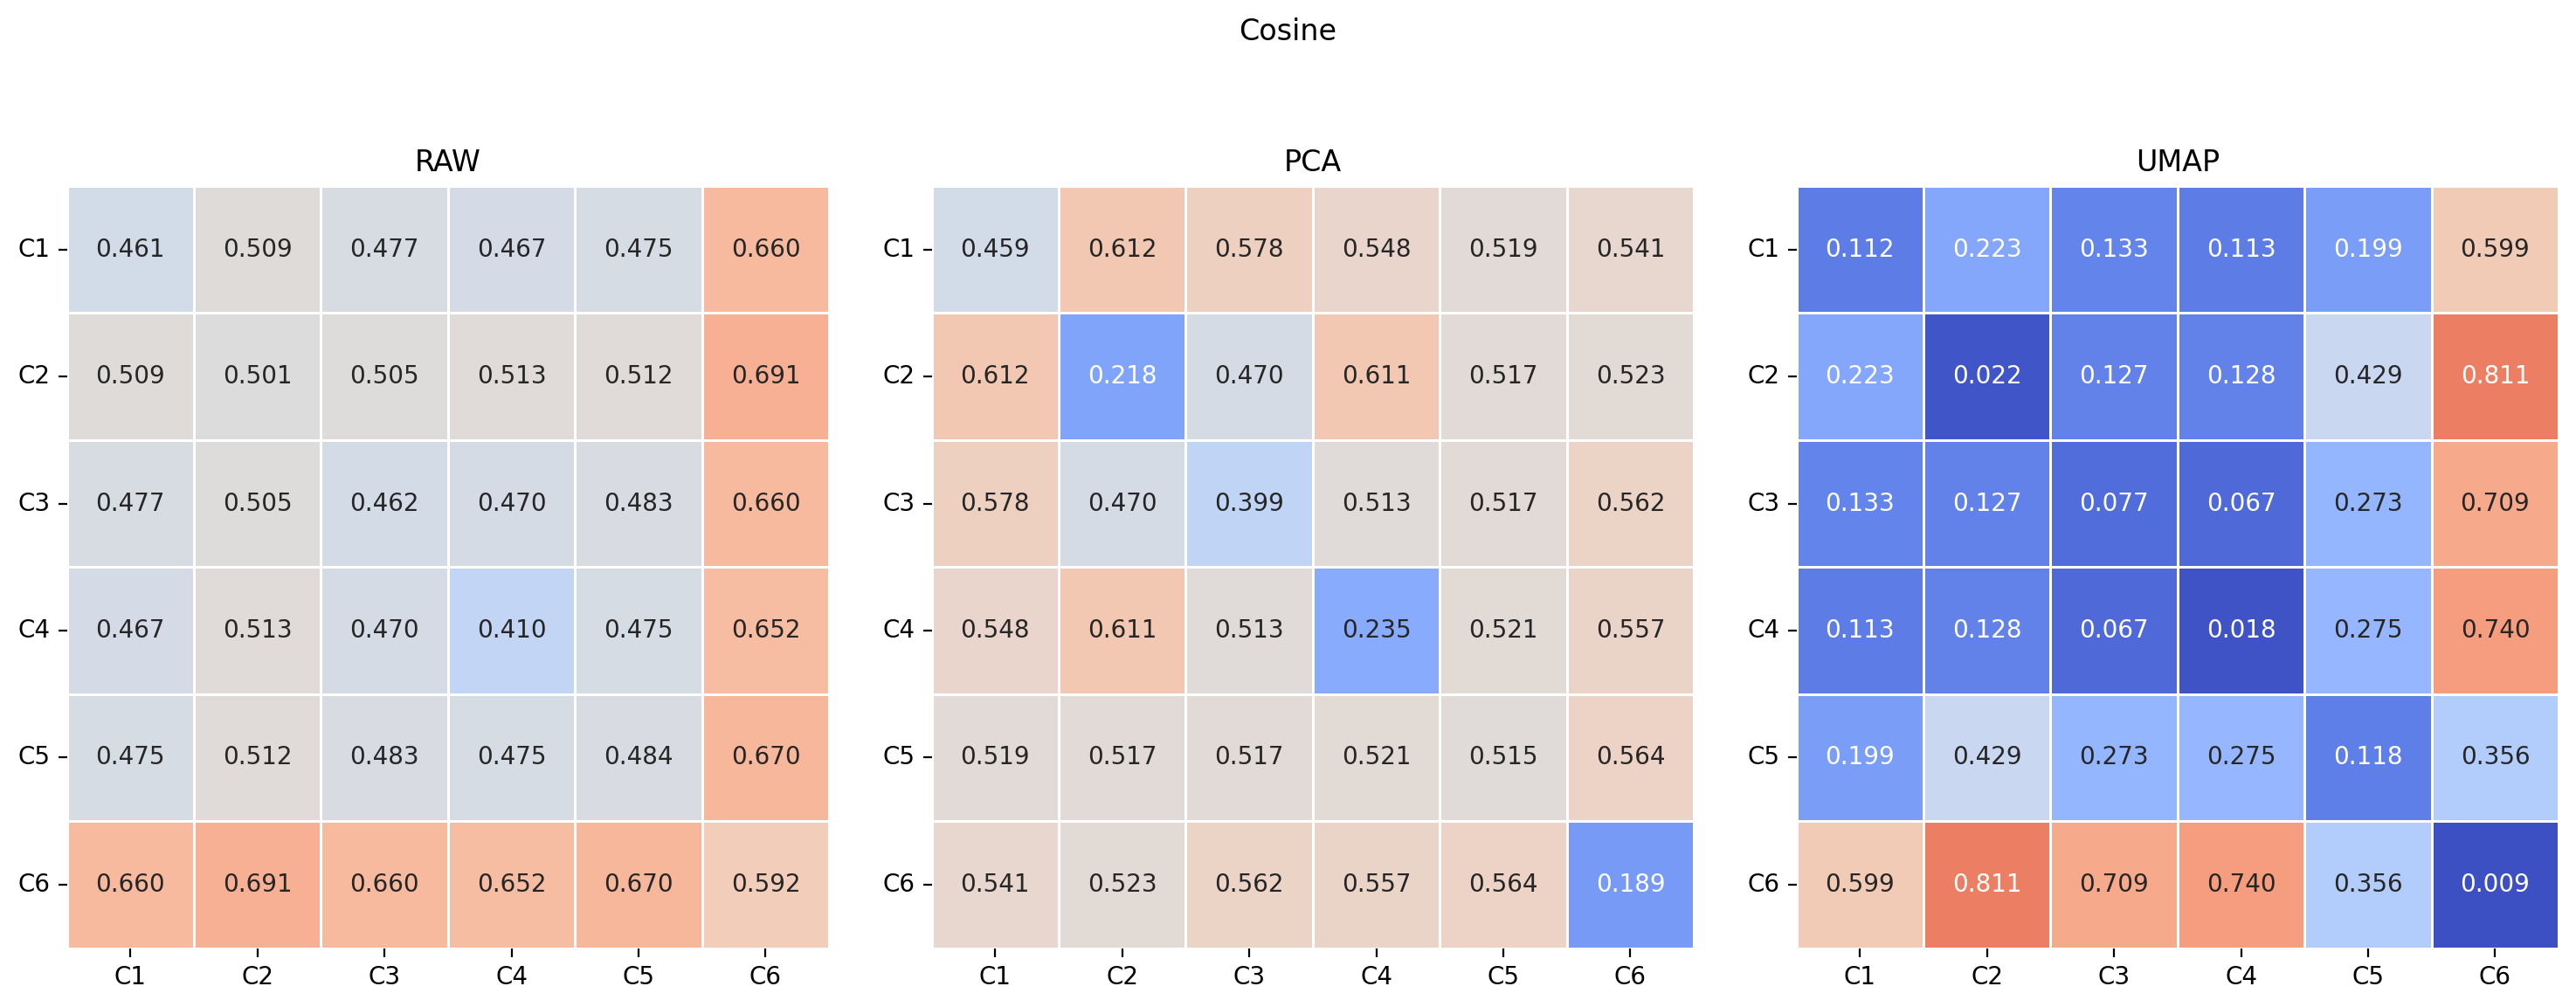

2 correlation raw (1000, 14599)
2 correlation pca (1000, 30)
2 correlation umap (1000, 30)


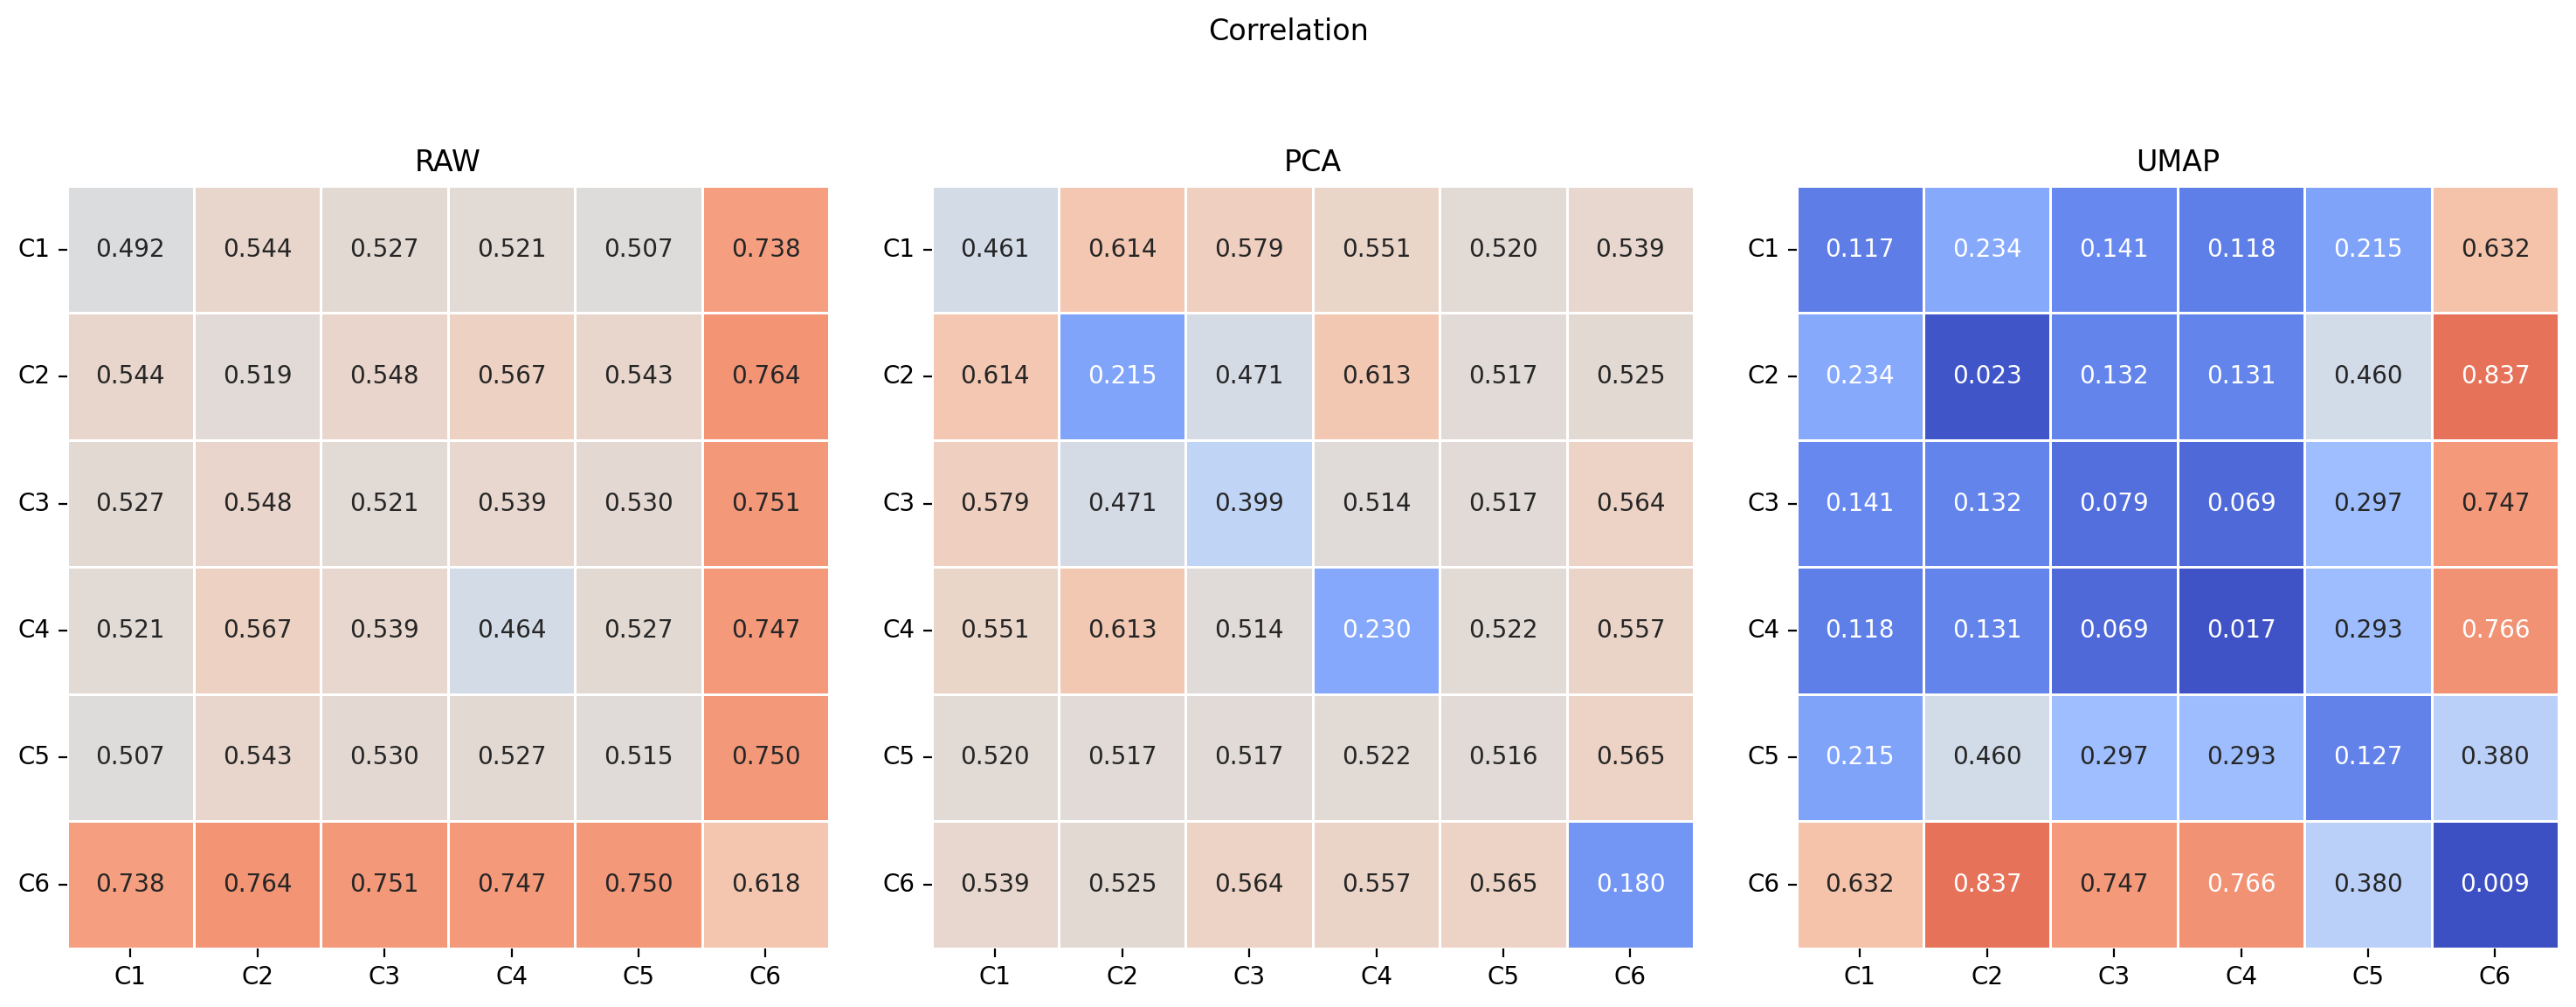

3 jensenshannon raw (1000, 14599)
3 jensenshannon pca (1000, 30)
3 jensenshannon umap (1000, 30)


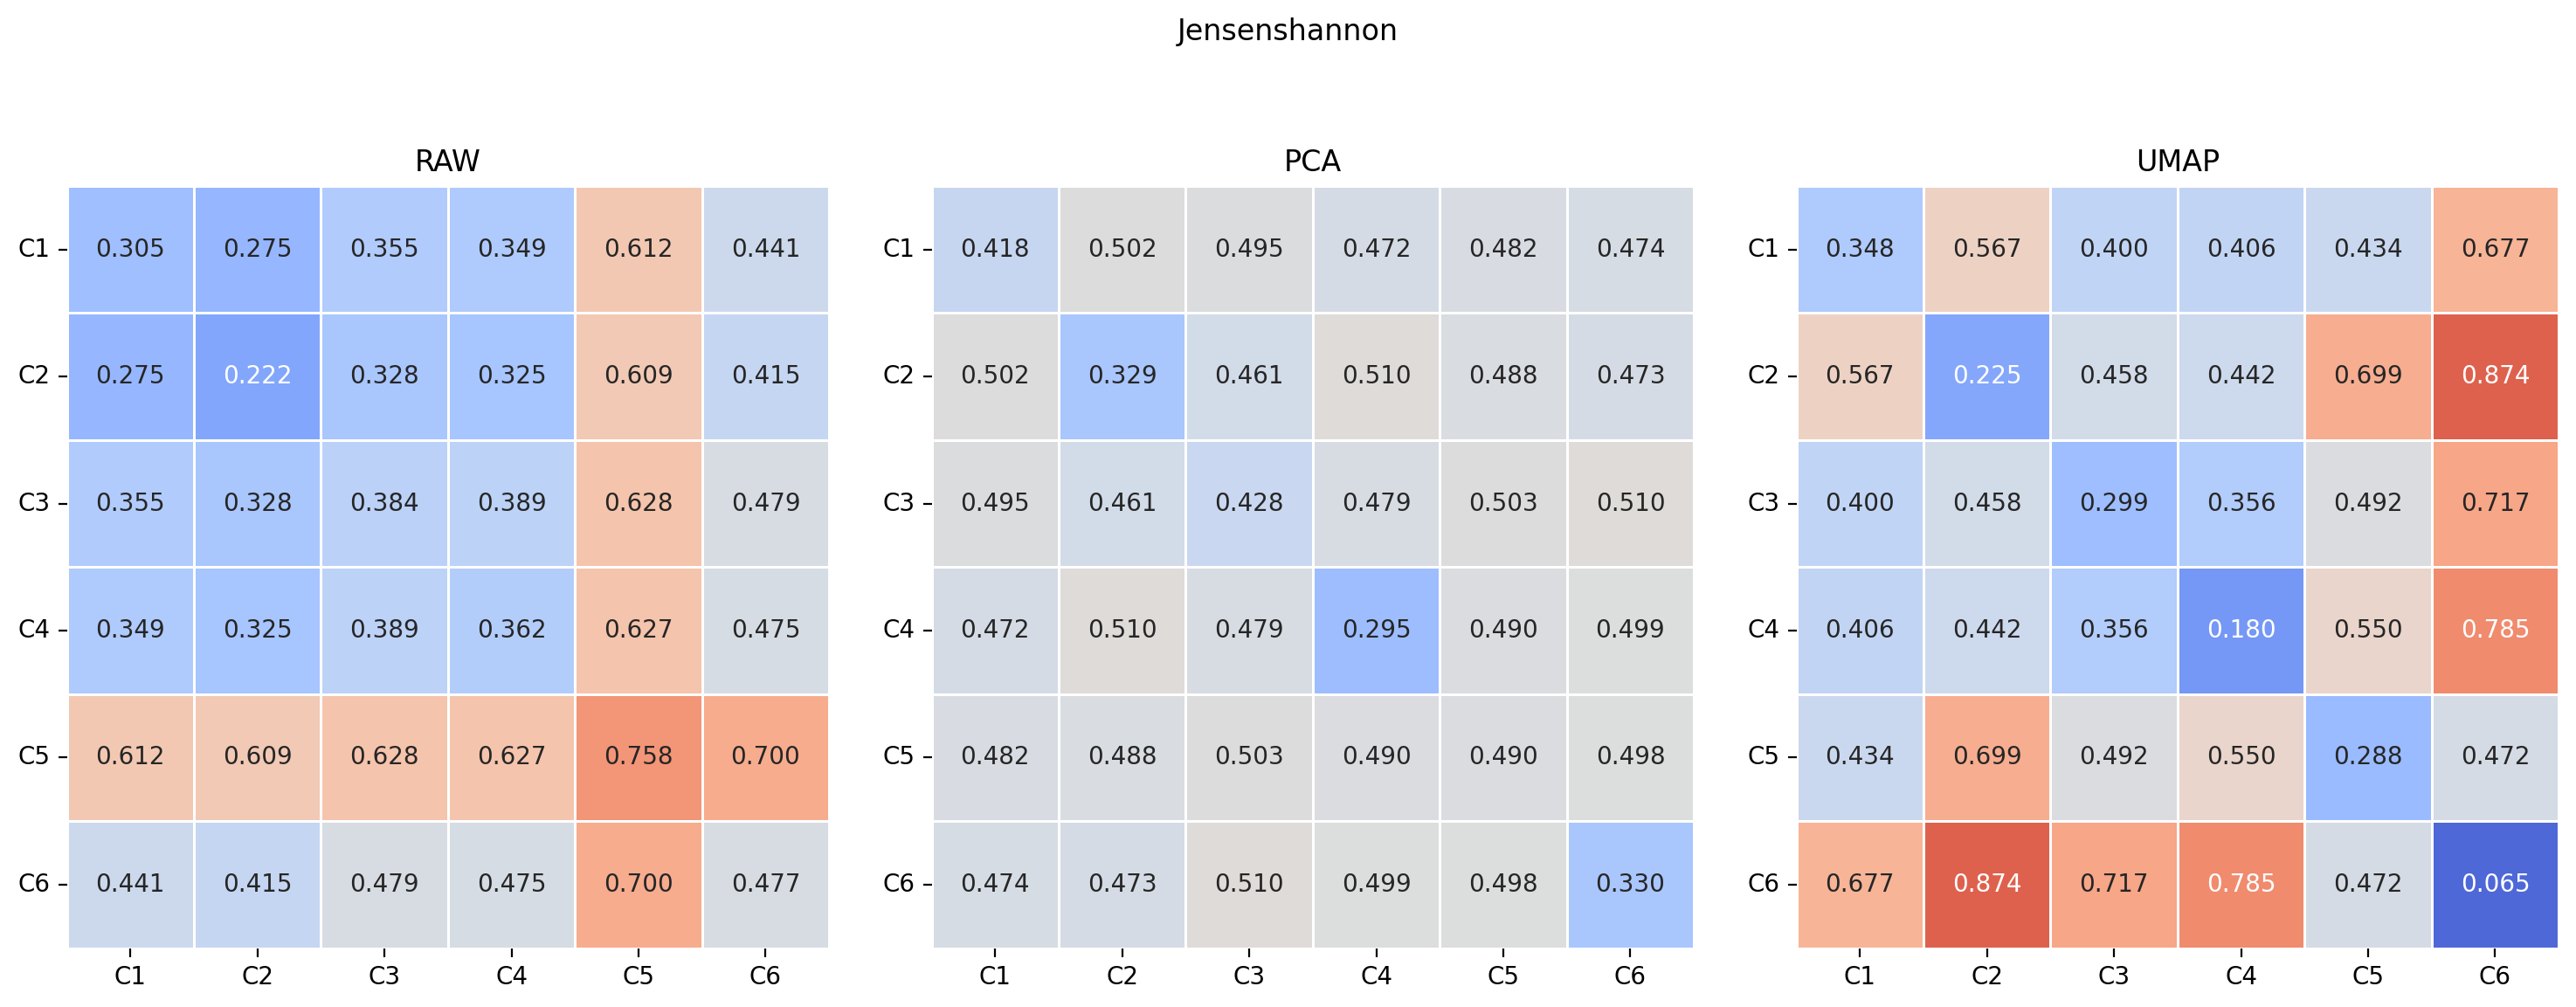

4 <function wasserstein_distance at 0x15314631b310> raw (1000, 14599)
4 <function wasserstein_distance at 0x15314631b310> pca (1000, 30)
4 <function wasserstein_distance at 0x15314631b310> umap (1000, 30)


AttributeError: 'function' object has no attribute 'title'

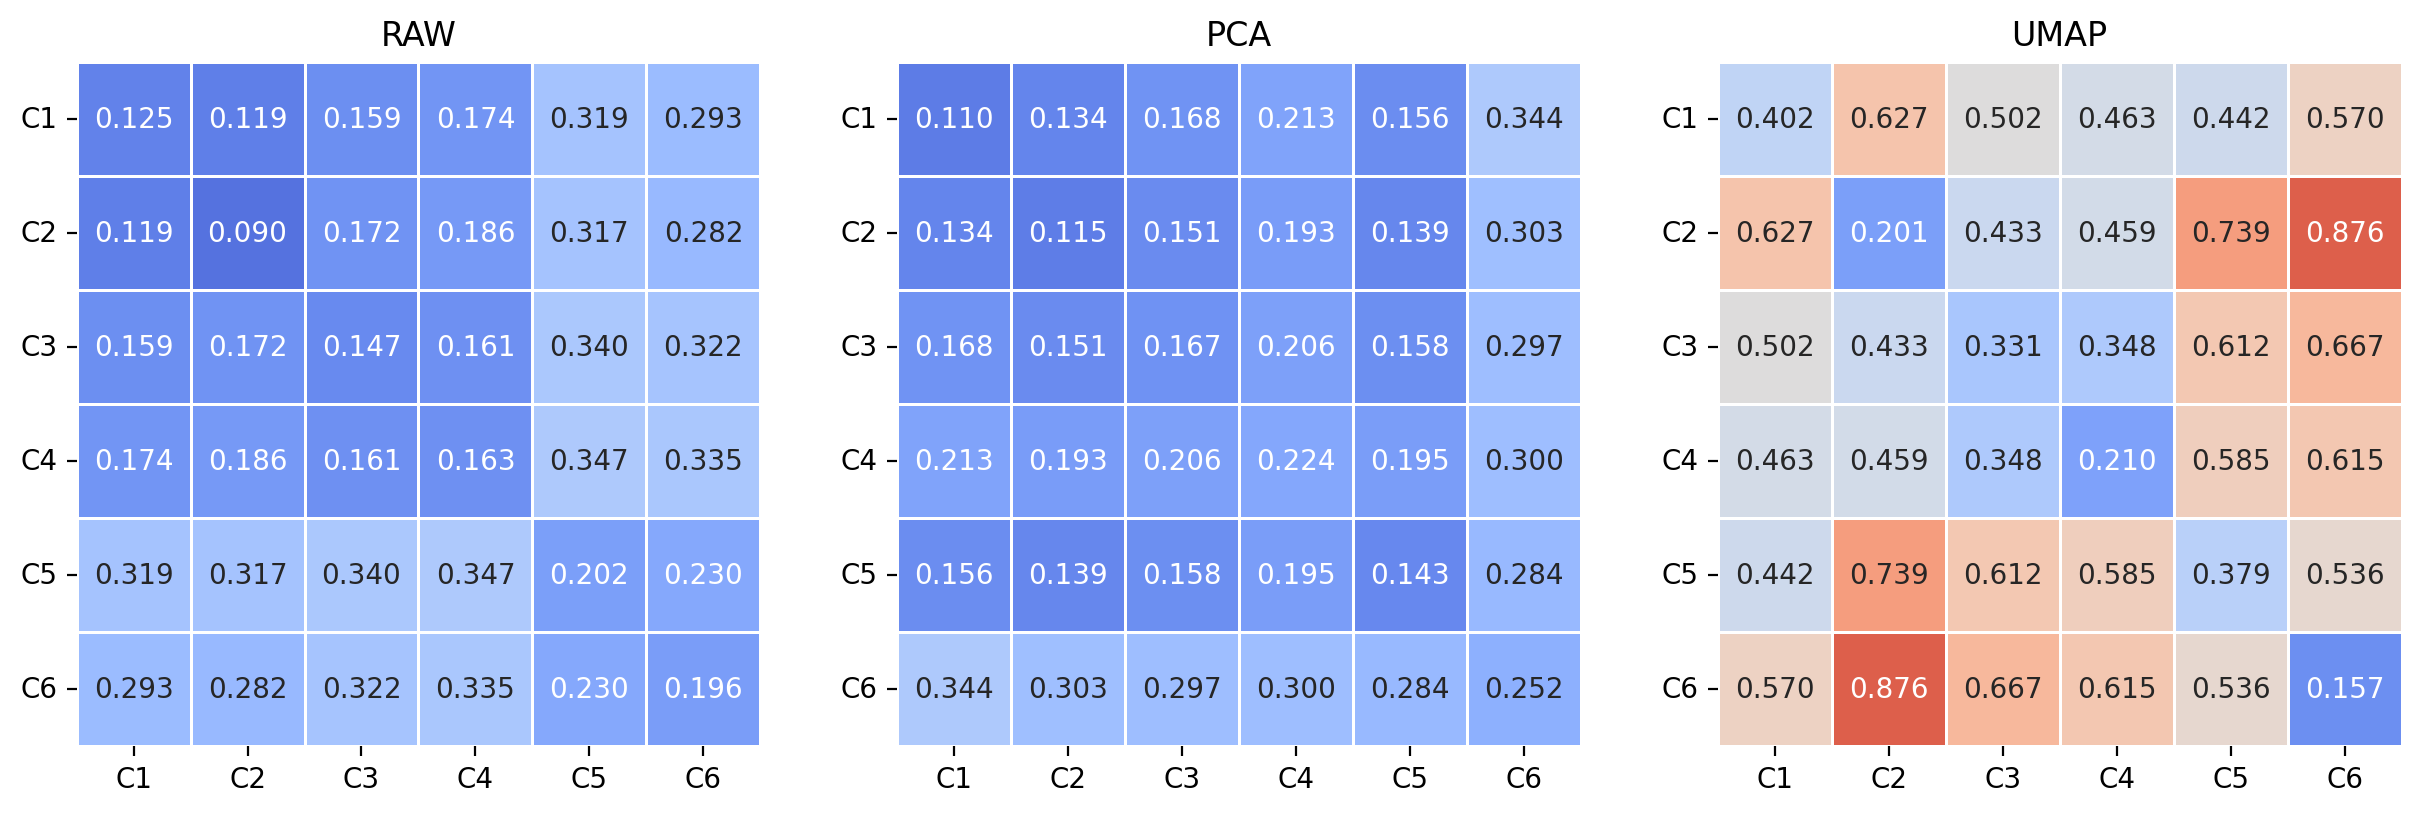

In [9]:
metrics = [
    'euclidean',
    'cosine',
    'correlation',
    'jensenshannon',
    scipy.stats.wasserstein_distance
]

cmap = 'coolwarm'

def get_mean_D(D, pdf):
    """A function to compute group mean statistics """
    # average distances
    res = []
    
    for i_name, group_i in pdf.obs.groupby('group'):
        for j_name, group_j in pdf.obs.groupby('group'):
            i_idx = group_i.index
            j_idx = group_j.index
        
            mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())
        
            row = {
                'i_name' : i_name,
                'j_name' : j_name,
                'mean_dist' : mean_dist,
            }
        
            res.append(row)
            
    res = pd.DataFrame(res)
    res = pd.pivot_table(res, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')
    return res

res = []
for i, metric in enumerate(metrics):

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 15, 5
    fig, axs = plt.subplots(1, 3)
    
    for j, (layer, X) in enumerate(layers.items()):
        print(i, metric, layer, X.shape)

        if metric == 'jensenshannon':
            # normalize the features of the matrix, 
            # since it expects probabilites
            X = preprocessing.minmax_scale(X, 
                                           feature_range=(0, 1),
                                           axis=1)

        # make distance matrix
        D = scipy.spatial.distance.pdist(X, metric=metric)
        
        # normalize the distances
        D = min_max(D)
        D = scipy.spatial.distance.squareform(D)
        D = pd.DataFrame(D, 
                         index=pdf.obs.index, 
                         columns=pdf.obs.index)

        # aggregate
        Dmu = get_mean_D(D, pdf)

        # plot the mean data
        sns.heatmap(Dmu, 
                    square=True,
                    linewidth=0.5,
                    annot=True,
                    cmap=cmap,
                    fmt=".3f",
                    vmin=0,
                    vmax=1,
                    cbar=False,
                    ax=axs[j])

        axs[j].set_title(layer.upper())
        axs[j].set_ylabel("")
        axs[j].set_xlabel("")
        axs[j].tick_params(axis='y', rotation=0)        

    plt.suptitle(metric, y=1.1)
    plt.tight_layout()
    plt.show()